## Importing Libraries



In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error
from itertools import product
import matplotlib.pyplot as plt

np.random.seed(42)

## GBOOST TREE NODES    
---

> This class defines a node which creates a tree structure by recursively calling itself whilst checking a number of ending parameters such as depth and min_leaf.
It uses an exact greedy method to exhaustively scan every possible split point.
Algorithm is based on Frieman's 2001 Gradient Boosting Machines.


<br>

### Class Functions:
---

**find_varsplit:**

        Scans through every column and calcuates the best split point.
        The node is then split at this point and two new nodes are created.
        Depth is only parameter to change as we have added a new layer to tree structure.
        If no split is better than the score initalised at the beginning then no splits further splits are made.

---
**find_greedy_split:**


        For a given feature calculates the gain at each split.
        Globally updates the best score if a better split point is found.

---
**gain:**

        Computes the gain for a specific split point based on Frieman's 2001 Gradient Boosting Machines

---
**compute_gamma:**

        This is the optimal leaf node value from Frieman's 2001 Gradient Boosting Machines for a GBM classifier. <br>
        It calculates the mean of gradients.

---
### Inputs:



> X: Pandas dataframe <br>
  y: Pandas Series <br>
  idxs: indices of data points which belong in a node <br>
  min_leaf: minimum number of samples needed to be classified as a non-leaf node <br>
  depth: sets the maximum depth allowed.

---
### Output:

> Regression tree that can be used in gradient booting for regression.

In [2]:
class Node:
    def __init__(self, x, y, idxs, min_leaf=5, depth = 10, split_type = "greedy",eps = 0.01):
        self.x, self.y = x, y
        self.idxs = idxs
        self.depth = depth
        self.min_leaf = min_leaf
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.val = self.compute_gamma(y[self.idxs])
        self.score = float('-inf')
        self.split_type = split_type
        self.find_varsplit()
        self.eps = eps

    def find_varsplit(self):

        if(self.split_type == "greedy"):
            for col in range(self.col_count):
                self.find_greedy_split(col)
        elif (self.split_type == "approximate"):
            for col in range(self.col_count):
                self.find_approx_split(col)

        for c in range(self.col_count): self.find_greedy_split(c)
        if self.is_leaf: return
        x = self.split_col

        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        self.lhs = Node(self.x, self.y, self.idxs[lhs], self.min_leaf, depth = self.depth-1)
        self.rhs = Node(self.x, self.y, self.idxs[rhs], self.min_leaf, depth = self.depth-1)

    def find_greedy_split(self, var_idx):

        x = self.x.values[self.idxs, var_idx]

        for r in range(self.row_count):
            lhs = x <= x[r]   # boolean array [true, false]
            rhs = x > x[r]

            if(rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf):continue
            curr_score = self.gain(lhs, rhs)
            if curr_score > self.score:
                self.var_idx = var_idx    # split parameter of the node
                self.score = curr_score
                self.split = x[r]

    def find_approx_split(self, col):
        x = self.x.values[self.idxs, col]
        hessian_ = list([1] * len(x))
        df = pd.DataFrame({'Feature': x, 'hess': hessian_, 'id': list(range(len(self.idxs)))})
        df.sort_values(by=['Feature'], ascending=True, inplace=True)
        df.reset_index(inplace=True)
        hess_sum = df['hess'].sum()
        if hess_sum <= 1e-8 :
            return
        # print(str(hess_sum)+": HESSS")
        df['rank'] = df.apply(lambda x: (sum(df[df['Feature'] <= x['Feature']]['hess'])) / hess_sum, axis=1)

        prev_idx = 0
        bins_done = 0
        prev_rank = 0
        total_bins = int(1 / 0.01)

        for i in range(0, len(df)):
            if (np.abs(df.loc[i, 'rank'] - prev_rank) >= 0.01):
                new_df = df[prev_idx:i]
                new_df.reset_index(inplace=True)
                prev_idx = i
                bins_done += 1
                self.solve_bin(new_df,col)

            if (bins_done >= total_bins - 1):
                new_df = df[prev_idx:]
                new_df.reset_index(inplace=True)
                self.solve_bin(new_df,col)
                break
                


    def solve_bin(self, df, col):
        for r in range(0, len(df)):
            split = df.loc[r,'Feature']

            lhs = df['Feature'] <= df.loc[r, 'Feature']
            lhs_indices = df.loc[lhs, 'id'].tolist()
            
            rhs = df['Feature'] > df.loc[r, 'Feature']
            rhs_indices = df.loc[rhs, 'id'].tolist()
            
            
            if (len(lhs_indices) < self.min_leaf or len(rhs_indices) < self.min_leaf):
                continue

            poss_score = self.gain(lhs_indices, rhs_indices)

            if poss_score > self.score:
                self.col = col
                self.score = poss_score
                self.split = split

    def gain(self, lhs, rhs):

        gradient = self.y[self.idxs]

        lhs_gradient = gradient[lhs].sum()
        lhs_n_intances = len(gradient[lhs])
        rhs_gradient = gradient[rhs].sum()
        rhs_n_intances = len(gradient[rhs])

        # Frieman's gain function
        gain = ((lhs_gradient**2/(lhs_n_intances)) + (rhs_gradient**2/(rhs_n_intances))
                - ((lhs_gradient + rhs_gradient)**2/(lhs_n_intances + rhs_n_intances)))
        return(gain)

    @staticmethod
    def compute_gamma(gradient):
        denominator = len(gradient)
        if denominator < 1e-8:  # Add a small value to avoid division by zero
            denominator = 1e-8
        return np.sum(gradient) / denominator

    @property
    def split_col(self):
        return self.x.values[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('-inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.predict_row(xi)

## DECISION TREE REGRESSOR
---

> This class is a Wrapper class that provides a scikit learn interface to the recursive regression tree above. It provides methods to fit and predict datapoints for a single decision tree.

### Inputs:



> X: Pandas dataframe <br>
      y: Pandas Series <br>
      min_leaf: minimum number of samples needed to be classified as a node <br>
      depth: sets the maximum depth allowed

---
### Output:

>  A regression tree which has all weights learnt.

In [3]:
class DecisionTreeRegressor:

    def fit(self, X, y, min_leaf = 5, depth = 5,split_type = "greedy"):
        self.dtree = Node(X, y, np.array(np.arange(len(y))), min_leaf, depth,split_type)
        return self

    def predict(self, X):
        return self.dtree.predict(X.values)

## GRADIENT BOOSTING REGRESSOR
---

> This class applies the methodology of gradeint boosting machines Friedman 2001 for regression. It uses the mean squared loss function to calculate the negative derivate.

---

### Inputs:

> X: Pandas dataframe <br>
      y: Pandas Series <br>
      min_leaf: minimum number of samples needed to be classified as a node <br>
      depth: sets the maximum depth allowed <br>
      Boosting_Rounds: number of boosting rounds or iterations

---

### Output:

>  Gradient boosting machine that can be used for regression.

In [4]:
class GradientBoostRegressor:
    def __init__(self, classification = False):
        self.estimators = []
        self.rmse = []
        self.rmse_kfold = []

    @staticmethod
    def MeanSquaredError(y, y_pred):
        return(np.mean((y - y_pred)**2))

    @staticmethod
    def negativeMeanSquaredErrorDerivitive(y, y_pred):
        return(2*(y-y_pred))
    
    def kfold_indices(self, data, k):
        fold_size = len(data) // k
        indices = np.arange(len(data))
        folds = []
        for i in range(k-1):
            test_indices = indices[(i+1) * fold_size: (i + 2) * fold_size]
            train_indices = indices[0: (i + 1) * fold_size]
            folds.append((train_indices, test_indices))
        return folds
    

    def SimulatedAnnealing(self,Y,gradients,pred,num_iter,initial_learning_rate):
        current_learning_rate = initial_learning_rate
        cur_energy = self.MeanSquaredError(Y,pred+current_learning_rate*gradients)
        Temp = np.sum((Y-pred)**2)
        Alpha = 0.85
        for i in range(num_iter):
            new_learning_rate = np.random.uniform(current_learning_rate - current_learning_rate/100, current_learning_rate + current_learning_rate/100)
            rand_energy =  self.MeanSquaredError(Y,pred+new_learning_rate*gradients)

            delta_energy = rand_energy-cur_energy
            delta_energy = delta_energy/Temp

            try:
                if np.exp(-delta_energy) >= np.random.uniform(0,1):
                    current_learning_rate = new_learning_rate
                    cur_energy = rand_energy
            except OverflowError:
                break

            Temp = Temp * (Alpha)
        return current_learning_rate

    def fit(self, X, y,test_X=None, test_y=None, depth = 5, min_leaf = 5, learning_rate = 0.1, boosting_rounds = 5,split_type = "greedy",verbose = True, method = "fixed", k_fold_cross_validation=False, initial_temperature = 5, cooling_rate = 1, beta1 = 0.8, beta2 = 0.999, epsilon = 1e-8):

        # Start with the mean y value as our initial prediciton
        self.y = y
        self.learning_rate = learning_rate
        self.base_pred = np.full((X.shape[0], 1), np.mean(y)).flatten()

        if (method=="fixed"):
          
            if(k_fold_cross_validation):
                indices = self.kfold_indices(X, boosting_rounds+1)
                
                for booster, (train_indices, test_indices) in zip(list(range(0,boosting_rounds)), indices):
                    X_train = X.iloc[np.array(train_indices)]
                    y_train = np.array([y[i] for i in train_indices])
                    X_test = X.iloc[np.array(test_indices)]
                    y_test = np.array([y[i] for i in test_indices])
                    X_train.reset_index(drop=True,inplace=True)
                    X_test.reset_index(drop=True,inplace=True)
                    
                    pseudo_residuals = self.negativeMeanSquaredErrorDerivitive(y, self.base_pred)
                    pseudo_residuals_new = pd.Series([pseudo_residuals[i] for i in train_indices])
                    boosting_tree = DecisionTreeRegressor().fit(X = X_train, y = pseudo_residuals_new, depth = depth, min_leaf = min_leaf,split_type=split_type)
                    self.base_pred += self.learning_rate * boosting_tree.predict(X)
                    self.estimators.append(boosting_tree)
                    new_pred= [self.base_pred[i] for i in train_indices]
                    rmse=(self.MeanSquaredError(y_train,new_pred))**0.5
                    rmse_kfold = np.sqrt(np.mean((self.predict(X_test) - y_test)**2))
                    self.rmse.append(rmse)
                    self.rmse_kfold.append(rmse_kfold)
                    if verbose:
                        print("Boosting round",booster+1,"/",boosting_rounds,"completed.")
                        print("TRAINING LOSS: ",rmse,end = "\t")
                        print("K-FOLD VALIDATION LOSS: ",(rmse_kfold),end = "\t")
                        if test_X is not None:
                            print("TESTING LOSS: ",(self.MeanSquaredError(test_y , self.predict(test_X)))**0.5)
                        else:
                            print()
            else:

                for booster in range(boosting_rounds):
                    # Calculate the initial Pseudo Residuals using Base Prediction.
                    pseudo_residuals = self.negativeMeanSquaredErrorDerivitive(y, self.base_pred)
                    boosting_tree = DecisionTreeRegressor().fit(X = X, y = pseudo_residuals,  depth = depth, min_leaf = min_leaf,split_type=split_type)
                    self.base_pred += self.learning_rate * boosting_tree.predict(X)
                    self.estimators.append(boosting_tree)
                    rmse=(self.MeanSquaredError(y,self.base_pred))**0.5
                    self.rmse.append(rmse)
                    if verbose:
                        print("Boosting round",booster+1,"/",boosting_rounds,"completed.")
                        print("TRAINING LOSS: ",rmse,end = "\t")
                        if test_X is not None:
                            print("TESTING LOSS: ",(self.MeanSquaredError(test_y , self.predict(test_X)))**0.5)
                        else:
                            print()
            

        elif (method=="simulated_annealing"):
            if(k_fold_cross_validation):
                indices = self.kfold_indices(X, boosting_rounds+1)
                
                for booster, (train_indices, test_indices) in zip(list(range(0,boosting_rounds)), indices):
                    X_train = X.iloc[np.array(train_indices)]
                    y_train = np.array([y[i] for i in train_indices])
                    X_test = X.iloc[np.array(test_indices)]
                    y_test = np.array([y[i] for i in test_indices])
                    X_train.reset_index(drop=True,inplace=True)
                    X_test.reset_index(drop=True,inplace=True)
                    
                    # Calculate the initial Pseudo Residuals using Base Prediction.
                    pseudo_residuals = self.negativeMeanSquaredErrorDerivitive(y, self.base_pred)
                    pseudo_residuals_new = pd.Series([pseudo_residuals[i] for i in train_indices])
                    boosting_tree = DecisionTreeRegressor().fit(X = X_train, y = pseudo_residuals_new,  depth = depth, min_leaf = min_leaf,split_type=split_type)
                    #Finding best learning rate for new predictions
                    self.learning_rate = self.SimulatedAnnealing(y,boosting_tree.predict(X),self.base_pred,100,self.learning_rate)
                    self.base_pred += self.learning_rate * boosting_tree.predict(X)
                    self.estimators.append(boosting_tree)
                    new_pred= [self.base_pred[i] for i in train_indices]
                    rmse=(self.MeanSquaredError(y_train,new_pred))**0.5
                    rmse_kfold = np.sqrt(np.mean((self.predict(X_test) - y_test)**2))
                    self.rmse.append(rmse)
                    self.rmse_kfold.append(rmse_kfold)
                    if verbose:
                        print("Boosting round",booster+1,"/",boosting_rounds,"completed.")
                        print("TRAINING LOSS: ",rmse,end = "\t")
                        print("K-FOLD VALIDATION LOSS: ",(rmse_kfold),end = "\t")
                        if test_X is not None:
                            print("TESTING LOSS: ",(self.MeanSquaredError(test_y , self.predict(test_X)))**0.5)
                        else:
                            print()
            else:

                for booster in range(boosting_rounds):

                    # Calculate the initial Pseudo Residuals using Base Prediction.
                    pseudo_residuals = self.negativeMeanSquaredErrorDerivitive(y, self.base_pred)
                    boosting_tree = DecisionTreeRegressor().fit(X = X, y = pseudo_residuals,  depth = depth, min_leaf = min_leaf,split_type=split_type)
                    #Finding best learning rate for new predictions
                    self.learning_rate = self.SimulatedAnnealing(y,boosting_tree.predict(X),self.base_pred,100,self.learning_rate)
                    self.base_pred += self.learning_rate * boosting_tree.predict(X)
                    self.estimators.append(boosting_tree)
                    rmse=(self.MeanSquaredError(y,self.base_pred))**0.5
                    self.rmse.append(rmse)
                    if verbose:
                        print("Boosting round",booster+1,"/",boosting_rounds,"completed.")
                        print("TRAINING LOSS: ",rmse,end = "\t")
                        if test_X is not None:
                            print("TESTING LOSS: ",(self.MeanSquaredError(test_y , self.predict(test_X)))**0.5)
                        else:
                            print()

        elif (method=="adam"):
          
            if(k_fold_cross_validation):
                indices = self.kfold_indices(X, boosting_rounds+1)
                
                for booster, (train_indices, test_indices) in zip(list(range(0,boosting_rounds)), indices):
                    X_train = X.iloc[np.array(train_indices)]
                    y_train = np.array([y[i] for i in train_indices])
                    X_test = X.iloc[np.array(test_indices)]
                    y_test = np.array([y[i] for i in test_indices])
                    X_train.reset_index(drop=True,inplace=True)
                    X_test.reset_index(drop=True,inplace=True)
                    
                    # Calculate the initial Pseudo Residuals using Base Prediction.
                    pseudo_residuals = self.negativeMeanSquaredErrorDerivitive(y, self.base_pred)
                    pseudo_residuals_new = pd.Series([pseudo_residuals[i] for i in train_indices])
                    boosting_tree = DecisionTreeRegressor().fit(X = X_train, y = pseudo_residuals_new,  depth = depth, min_leaf = min_leaf,split_type=split_type)
                    #Finding best learning rate for new predictions
                    self.learning_rate = self.SimulatedAnnealing(y,boosting_tree.predict(X),self.base_pred,100,self.learning_rate)
                    self.base_pred += self.learning_rate * boosting_tree.predict(X)
                    self.estimators.append(boosting_tree)
                    new_pred= [self.base_pred[i] for i in train_indices]
                    rmse=(self.MeanSquaredError(y_train,new_pred))**0.5
                    rmse_kfold = np.sqrt(np.mean((self.predict(X_test) - y_test)**2))
                    self.rmse.append(rmse)
                    self.rmse_kfold.append(rmse_kfold)
                    if verbose:
                        print("Boosting round",booster+1,"/",boosting_rounds,"completed.")
                        print("TRAINING LOSS: ",rmse,end = "\t")
                        print("K-FOLD VALIDATION LOSS: ",(rmse_kfold),end = "\t")
                        if test_X is not None:
                            print("TESTING LOSS: ",(self.MeanSquaredError(test_y , self.predict(test_X)))**0.5)
                        else:
                            print()

            else:

                m = np.zeros(shape=self.base_pred.shape)
                v = np.zeros(shape=self.base_pred.shape)
                for booster in range(boosting_rounds):
                    pseudo_residuals = self.negativeMeanSquaredErrorDerivitive(y, self.base_pred)
                    boosting_tree = DecisionTreeRegressor().fit(X = X, y = pseudo_residuals, depth = 5, min_leaf = 5,split_type=split_type)

                    gradients = boosting_tree.predict(X)
                    m = beta1*m + (1-beta1)*gradients
                    v = beta2*v + (1-beta2)*(gradients**2)
                    m_hat = m / (1 - beta1**(booster+1))
                    v_hat = v / (1 - beta2**(booster+1))
                    new_gradients = m_hat / (np.sqrt(v_hat) + epsilon)
                    self.base_pred += self.learning_rate * new_gradients
                    self.estimators.append(boosting_tree)
                    rmse=(self.MeanSquaredError(y,self.base_pred))**0.5
                    self.rmse.append(rmse)
                    if verbose:
                        print("Boosting round",booster+1,"/",boosting_rounds,"completed.")
                        print("TRAINING LOSS: ",rmse,end = "\t")
                        if test_X is not None:
                            print("TESTING LOSS: ",(self.MeanSquaredError(test_y , self.predict(test_X)))**0.5)
                        else:
                            print()

    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for estimator in self.estimators:
            pred += self.learning_rate * estimator.predict(X)

        return np.full((X.shape[0], 1), np.mean(self.y)).flatten() + pred

## Loading the dataframe

In [5]:
with open('dataframe.pickle', 'rb') as f:
    df = pickle.load(f)

df.head()

,Datetime,PJME_MW,Lag1,Lag2,Hour_sin,Hour_cos,Day_sin,Day_cos
0,2004-12-31 01:00:00,27160.0,27077.0,25591.0,0.258819,0.965926,-2.449294e-16,1.0
1,2004-12-31 02:00:00,25791.0,25957.0,24235.0,0.500000,0.866025,-2.449294e-16,1.0
2,2004-12-31 03:00:00,25052.0,24930.0,23121.0,0.707107,0.707107,-2.449294e-16,1.0
3,2004-12-31 04:00:00,24797.0,24359.0,22445.0,0.866025,0.500000,-2.449294e-16,1.0
4,2004-12-31 05:00:00,25026.0,24400.0,22332.0,0.965926,0.258819,-2.449294e-16,1.0


### Dataset

In [6]:
num_rows = df.shape[0]
df=df[:10]

# 80-20 split
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

train_df=train_df.drop(columns=['Datetime'])
test_df=test_df.drop(columns=['Datetime'])

In [7]:
print("Training dataframe shape: ",train_df.shape)
print("Testing dataframe shape: ",test_df.shape)

Training dataframe shape:  (8, 7)
Testing dataframe shape:  (2, 7)


In [8]:
train_df.head()

,PJME_MW,Lag1,Lag2,Hour_sin,Hour_cos,Day_sin,Day_cos
8,29994.0,26380.0,24637.0,0.707107,-7.071068e-01,-2.449294e-16,1.0
1,25791.0,25957.0,24235.0,0.500000,8.660254e-01,-2.449294e-16,1.0
5,25977.0,24949.0,22790.0,1.000000,6.123234e-17,-2.449294e-16,1.0
0,27160.0,27077.0,25591.0,0.258819,9.659258e-01,-2.449294e-16,1.0
7,28786.0,25953.0,23860.0,0.866025,-5.000000e-01,-2.449294e-16,1.0


## Hyper-parameter Tuning

In [9]:


# # Define the parameter grid
# param_grid = {
#     'depth': [3, 5, 7],
#     'min_leaf': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.5],
#     'boosting_rounds': [5, 10, 15],
#     'initial_temperature' : [5],
#     'cooling_rate' : [1],
#     'beta1' : [0.8, 0.9],
#     'beta2' : [0.999],
#     'method': ['fixed', 'simulated_annealing', 'adam']
# }

# model = GradientBoostingRegressor()
# train_df=train_df.reset_index(drop=True)
# old_rmse=1e8
# params=[]

# # Fit the model
# X=train_df.drop(columns = ['PJME_MW'])
# y=train_df['PJME_MW']

# for depth in param_grid['depth']:
#   for min_leaf in param_grid['min_leaf']:
#     for learning_rate in param_grid['learning_rate']:
#           for boosting_rounds in param_grid['boosting_rounds']:
#                 for initial_temperature in param_grid['initial_temperature']:
#                       for cooling_rate in param_grid['cooling_rate']:
#                             for beta1 in param_grid['beta1']:
#                                   for beta2 in param_grid['beta2']:
#                                       for method in param_grid['method']:

#                                             model.fit(X,y , depth=depth, min_leaf=min_leaf, learning_rate=learning_rate, boosting_rounds=boosting_rounds,initial_temperature=initial_temperature,cooling_rate=cooling_rate,beta1=beta1,beta2=beta2, method = method)
#                                             predictions = model.predict(test_df.drop(columns = ['PJME_MW']))
#                                             Actual_Values = np.array(test_df['PJME_MW'])
#                                             rmse=(model.MeanSquaredError(Actual_Values,predictions))**0.5

#                                             if rmse<old_rmse:
#                                               old_rmse=rmse
#                                               params=[depth,min_leaf,learning_rate,boosting_rounds,initial_temperature,cooling_rate,beta1,beta2,method]




In [10]:
# print(mse)
# print(params)

## Training

In [9]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)
    new_df=new_df[:10]
X = new_df.drop(columns=['PJME_MW','Datetime'])
y = new_df['PJME_MW']
model = GradientBoostRegressor()
model.fit(X,y , test_X=X, test_y=y ,depth=5, min_leaf=5, learning_rate=0.1, split_type="greedy",boosting_rounds=5, method = "fixed")

Boosting round 1 / 5 completed.
TRAINING LOSS:  1910.0312077031613	TESTING LOSS:  1910.0312077031613
Boosting round 2 / 5 completed.
TRAINING LOSS:  1712.379426297524	TESTING LOSS:  1712.3794262975252
Boosting round 3 / 5 completed.
TRAINING LOSS:  1556.8421776951684	TESTING LOSS:  1556.8421776951684
Boosting round 4 / 5 completed.
TRAINING LOSS:  1415.3923546144056	TESTING LOSS:  1415.3923546144065
Boosting round 5 / 5 completed.
TRAINING LOSS:  1306.4544157797216	TESTING LOSS:  1306.4544157797227


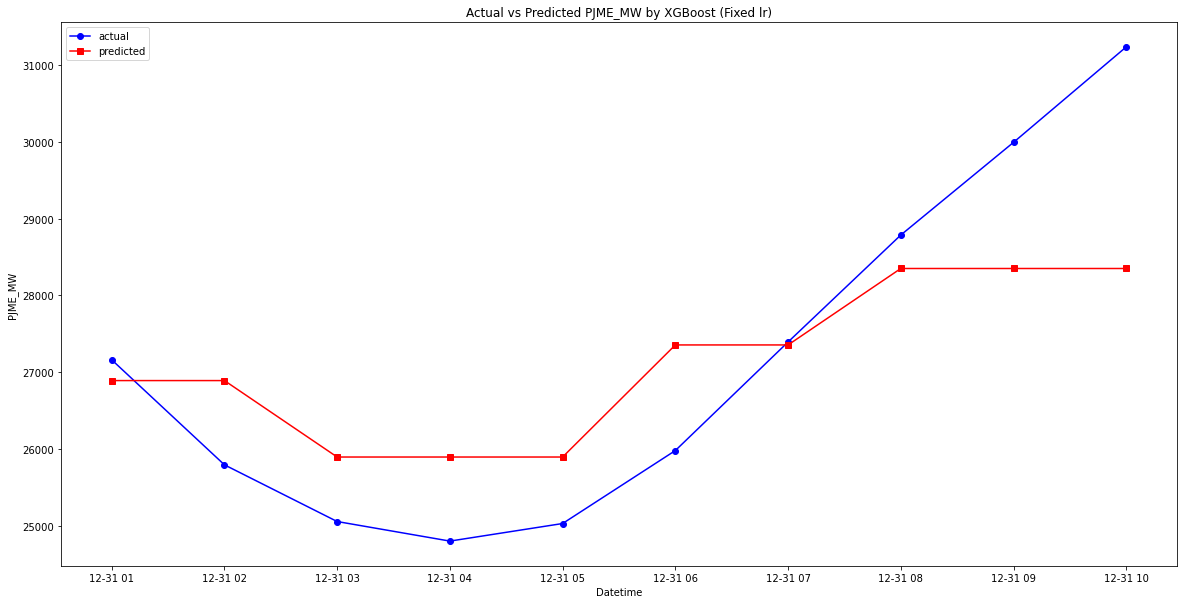

In [10]:
plt.figure(figsize=(20,10))
plt.plot(new_df['Datetime'], y, label='actual',color='blue', marker='o')

plt.plot(new_df['Datetime'], model.predict(X), label='predicted',color='red', marker='s')

plt.xlabel('Datetime')
plt.ylabel('PJME_MW')

plt.title('Actual vs Predicted PJME_MW by XGBoost (Fixed lr)')

plt.legend()
plt.show()

In [11]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)
    new_df=new_df[:10]
X = new_df.drop(columns=['PJME_MW','Datetime'])
y = new_df['PJME_MW']
model = GradientBoostRegressor()
model.fit(X,y , depth=5, min_leaf=5, learning_rate=0.1, boosting_rounds=5, split_type="greedy",method = "simulated_annealing")

Boosting round 1 / 5 completed.
TRAINING LOSS:  1894.8061422004062	
Boosting round 2 / 5 completed.
TRAINING LOSS:  1651.4488768939698	
Boosting round 3 / 5 completed.
TRAINING LOSS:  1450.8411295106407	
Boosting round 4 / 5 completed.
TRAINING LOSS:  1287.487332612693	
Boosting round 5 / 5 completed.
TRAINING LOSS:  1170.2280616871558	


C:\Users\sahil\AppData\Local\Temp\ipykernel_16784\1558226921.py:39: RuntimeWarning: overflow encountered in exp
  if np.exp(-delta_energy) >= np.random.uniform(0,1):
C:\Users\sahil\AppData\Local\Temp\ipykernel_16784\1558226921.py:39: RuntimeWarning: overflow encountered in exp
  if np.exp(-delta_energy) >= np.random.uniform(0,1):
C:\Users\sahil\AppData\Local\Temp\ipykernel_16784\1558226921.py:39: RuntimeWarning: overflow encountered in exp
  if np.exp(-delta_energy) >= np.random.uniform(0,1):
C:\Users\sahil\AppData\Local\Temp\ipykernel_16784\1558226921.py:39: RuntimeWarning: overflow encountered in exp
  if np.exp(-delta_energy) >= np.random.uniform(0,1):
C:\Users\sahil\AppData\Local\Temp\ipykernel_16784\1558226921.py:39: RuntimeWarning: overflow encountered in exp
  if np.exp(-delta_energy) >= np.random.uniform(0,1):


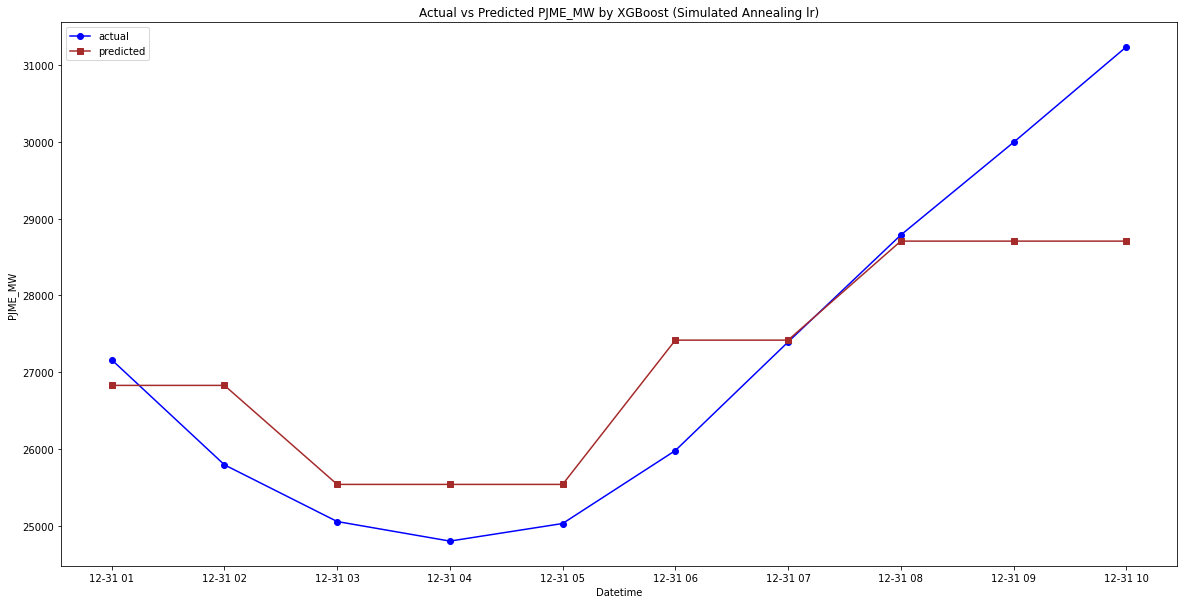

In [12]:
plt.figure(figsize=(20,10))
plt.plot(new_df['Datetime'], y, label='actual',color='blue', marker='o')

plt.plot(new_df['Datetime'], model.predict(X), label='predicted',color='brown', marker='s')

plt.xlabel('Datetime')
plt.ylabel('PJME_MW')

plt.title('Actual vs Predicted PJME_MW by XGBoost (Simulated Annealing lr)')

plt.legend()
plt.show()

In [13]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)
    new_df=new_df[:10]
X = new_df.drop(columns=['PJME_MW','Datetime'])
y = new_df['PJME_MW']
model = GradientBoostRegressor()
model.fit(X,y , depth=5, min_leaf=5, learning_rate=0.1, boosting_rounds=5, method = "adam")



Boosting round 1 / 5 completed.
TRAINING LOSS:  2125.9419088959144	
Boosting round 2 / 5 completed.
TRAINING LOSS:  2125.8687191607514	
Boosting round 3 / 5 completed.
TRAINING LOSS:  2125.7955320405654	
Boosting round 4 / 5 completed.
TRAINING LOSS:  2125.72234770198	
Boosting round 5 / 5 completed.
TRAINING LOSS:  2125.6491663059614	


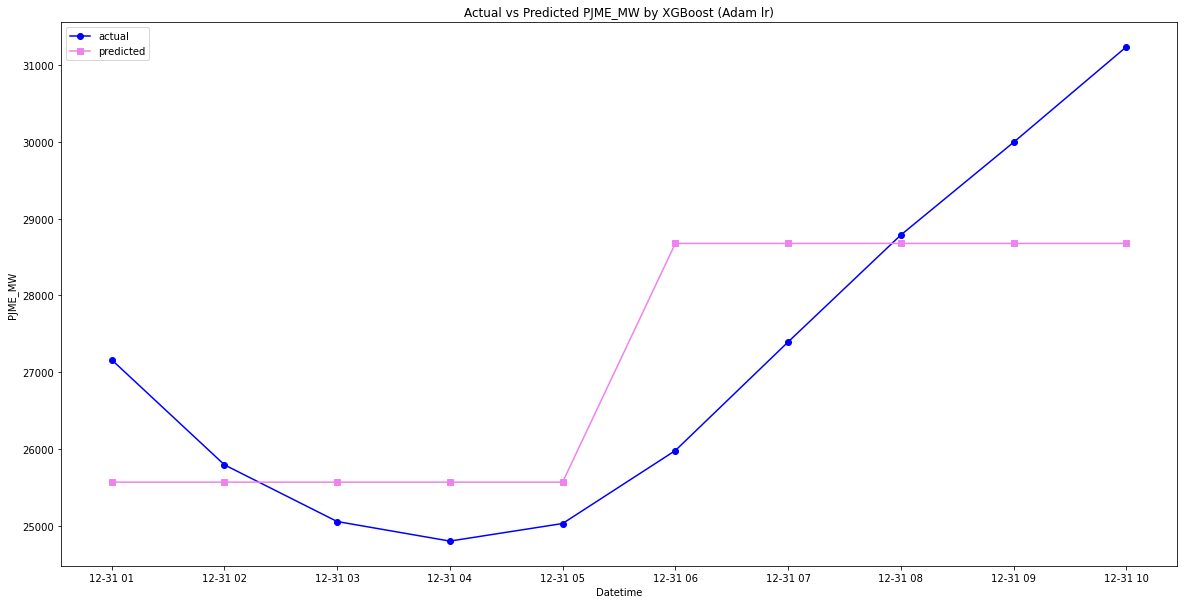

In [14]:
plt.figure(figsize=(20,10))
plt.plot(new_df['Datetime'], y, label='actual',color='blue', marker='o')

plt.plot(new_df['Datetime'], model.predict(X), label='predicted',color='violet', marker='s')

plt.xlabel('Datetime')
plt.ylabel('PJME_MW')

plt.title('Actual vs Predicted PJME_MW by XGBoost (Adam lr)')

plt.legend()
plt.show()

## Library Method

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import pickle

In [16]:
with open('dataframe.pickle', 'rb') as f:
    df = pickle.load(f)
    df=df[:10]

X=df.drop(columns = ['PJME_MW','Datetime'])
y=df['PJME_MW']

In [17]:
gb_regressor = GradientBoostingRegressor(n_estimators=5, learning_rate=0.2, max_depth=5, random_state=42)
gb_regressor.fit(X, y)
final_loss = gb_regressor.train_score_[-1]
print("Final MSE Loss:", final_loss)
print("Final RMSE Loss:", (final_loss)**0.5)

Final MSE Loss: 485324.8845456334
Final RMSE Loss: 696.6526283203368


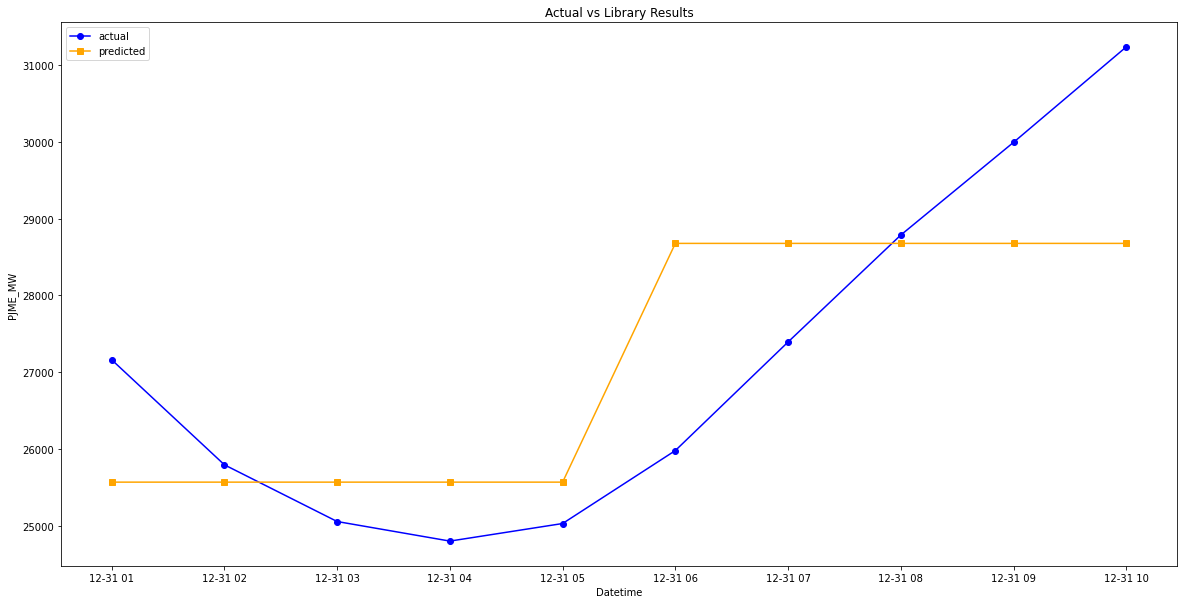

In [18]:
plt.figure(figsize=(20,10))
plt.plot(new_df['Datetime'], y, label='actual',color='blue', marker='o')

plt.plot(new_df['Datetime'], model.predict(X), label='predicted',color='orange', marker='s')

plt.xlabel('Datetime')
plt.ylabel('PJME_MW')

plt.title('Actual vs Library Results')

plt.legend()
plt.show()

---------------------------------------------------------------------------------------------------------------

##### TRAINING ON SMALLER DATASET

------------------------------------------------------------------------------------------------------------

##### USING GREEDY

In [19]:
def Fit_Model_SD(learning_rate_method):
    with open('dataframe.pickle', 'rb') as f:
        new_df = pickle.load(f)
    new_df = new_df [(new_df['Datetime'] >= '2010-01') & (new_df['Datetime'] <= '2012-01')]
    new_df=new_df[:10]
    new_df.reset_index(inplace=True, drop=True)
    X = new_df.drop(columns=['PJME_MW','Datetime'])
    Y = new_df['PJME_MW']
    
    model = GradientBoostRegressor()
    model.fit(X,Y,min_leaf = 5,depth = 5,boosting_rounds = 20,
            learning_rate=0.4,split_type="greedy",method=learning_rate_method,verbose=False)
    
    return model

In [20]:
model_fixed = Fit_Model_SD("fixed")
print("Fixed Done!")
model_SA = Fit_Model_SD("simulated_annealing")
print("Simulated Done!")
model_Adam = Fit_Model_SD("adam")
print("Adam Done!")

Fixed Done!
Simulated Done!
Adam Done!


In [21]:
Rmse_Fixed = model_fixed.rmse
Rmse_SA = model_SA.rmse
Rmse_Adam = model_Adam.rmse

In [22]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)
    # new_df=new_df[:10]
    new_df = new_df [(new_df['Datetime'] >= '2010-01') & (new_df['Datetime'] <= '2012-01')]

X=new_df.drop(columns = ['PJME_MW','Datetime'])
y=new_df['PJME_MW']

model_Lib = GradientBoostingRegressor(n_estimators=20, learning_rate=0.2, max_depth=5, random_state=42)
model_Lib.fit(X, y)
Rmse_Lib = []

# Iterate over the predictions at each stage and calculate RMSE
for i, y_pred in enumerate(model_Lib.staged_predict(X)):
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    Rmse_Lib.append(rmse)
    print(f"Iteration {i+1}: RMSE = {rmse}")

# Get the RMSE of the final model
# Rmse_Lib = np.sqrt(mean_squared_error(y, model_Lib.predict(X)))
# print(f"Final RMSE: {Rmse_Lib}")
# print("Final MSE Loss:", final_loss)
# print("Final RMSE Loss:", (final_loss)**0.5)
# evals_result = model_Lib.evals_result()
# Rmse_Lib = evals_result['validation_0']['rmse']

Iteration 1: RMSE = 5875.3191028452375
Iteration 2: RMSE = 5200.370107943789
Iteration 3: RMSE = 4674.4795601560845
Iteration 4: RMSE = 4292.364560048271
Iteration 5: RMSE = 4012.41972283763
Iteration 6: RMSE = 3794.42911756857
Iteration 7: RMSE = 3636.3916652583953
Iteration 8: RMSE = 3505.108386345001
Iteration 9: RMSE = 3420.059237229758
Iteration 10: RMSE = 3328.016071810484
Iteration 11: RMSE = 3257.1477634164867
Iteration 12: RMSE = 3180.5212711597956
Iteration 13: RMSE = 3133.225818543513
Iteration 14: RMSE = 3092.8788141874397
Iteration 15: RMSE = 3037.1848239586034
Iteration 16: RMSE = 3009.9276924290866
Iteration 17: RMSE = 2977.286793428585
Iteration 18: RMSE = 2955.610314160474
Iteration 19: RMSE = 2930.4424645241934
Iteration 20: RMSE = 2916.473788081992


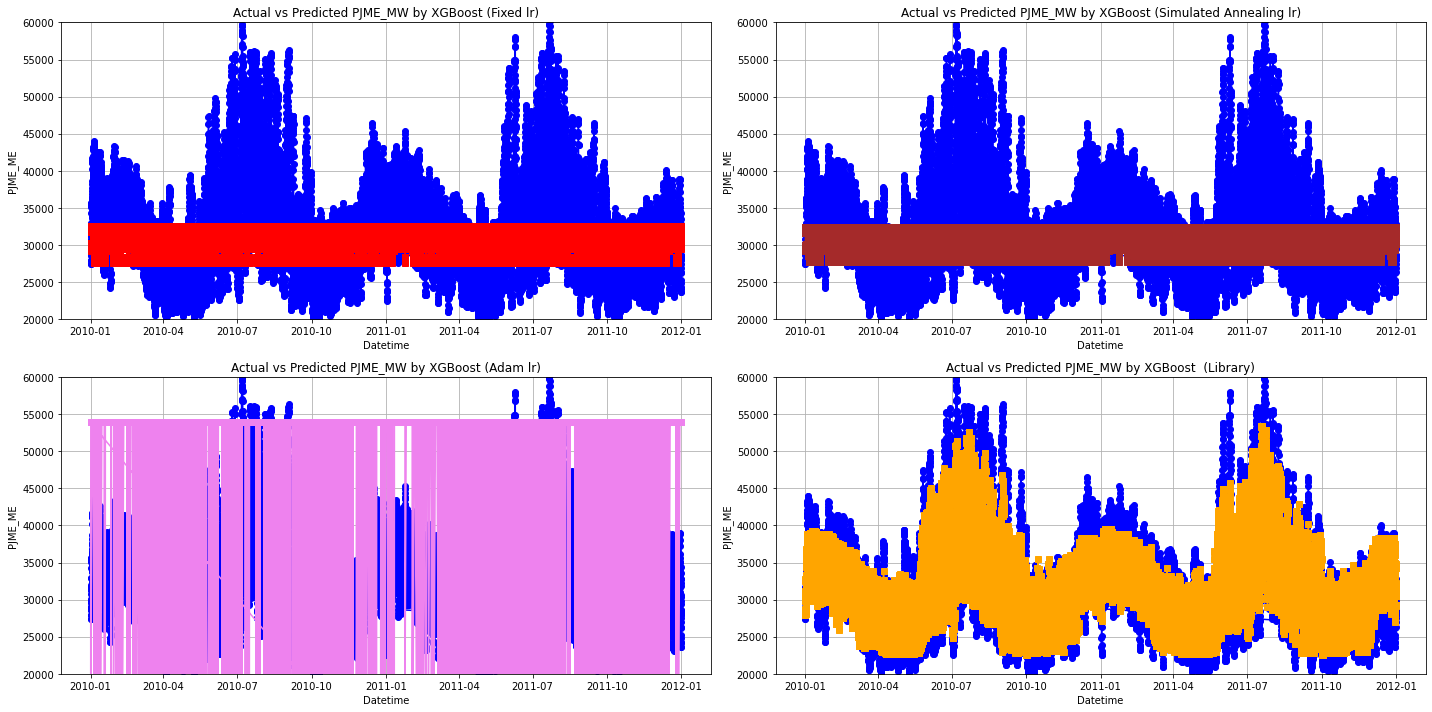

In [23]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)
new_df = new_df [(new_df['Datetime'] >= '2010-01') & (new_df['Datetime'] <= '2012-01')]
X = new_df.drop(columns=['PJME_MW','Datetime'])
Y = new_df['PJME_MW']


fig, axs = plt.subplots(2, 2, figsize=(20, 10))

axs[0, 0].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[0, 0].plot(new_df['Datetime'], model_fixed.predict(X), label='predicted',color='red', marker='s')
axs[0, 0].set_ylim(20_000, 60_000)
axs[0, 0].set_title('Actual vs Predicted PJME_MW by XGBoost (Fixed lr)')
axs[0, 0].set_xlabel('Datetime')
axs[0, 0].set_ylabel('PJME_ME')
axs[0, 0].grid(True)

axs[0, 1].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[0, 1].plot(new_df['Datetime'], model_SA.predict(X), label='predicted',color='brown', marker='s')
axs[0, 1].set_ylim(20_000, 60_000)
axs[0, 1].set_title('Actual vs Predicted PJME_MW by XGBoost (Simulated Annealing lr)')
axs[0, 1].set_xlabel('Datetime')
axs[0, 1].set_ylabel('PJME_ME')
axs[0, 1].grid(True)

axs[1, 0].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[1, 0].plot(new_df['Datetime'], model_Adam.predict(X), label='predicted',color='violet', marker='s')
axs[1, 0].set_ylim(20_000, 60_000)
axs[1, 0].set_title('Actual vs Predicted PJME_MW by XGBoost (Adam lr)')
axs[1, 0].set_xlabel('Datetime')
axs[1, 0].set_ylabel('PJME_ME')
axs[1, 0].grid(True)

axs[1, 1].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[1, 1].plot(new_df['Datetime'], model_Lib.predict(X), label='predicted',color='orange', marker='s')
axs[1, 1].set_ylim(20_000, 60_000)
axs[1, 1].set_title('Actual vs Predicted PJME_MW by XGBoost  (Library)')
axs[1, 1].set_xlabel('Datetime')
axs[1, 1].set_ylabel('PJME_ME')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

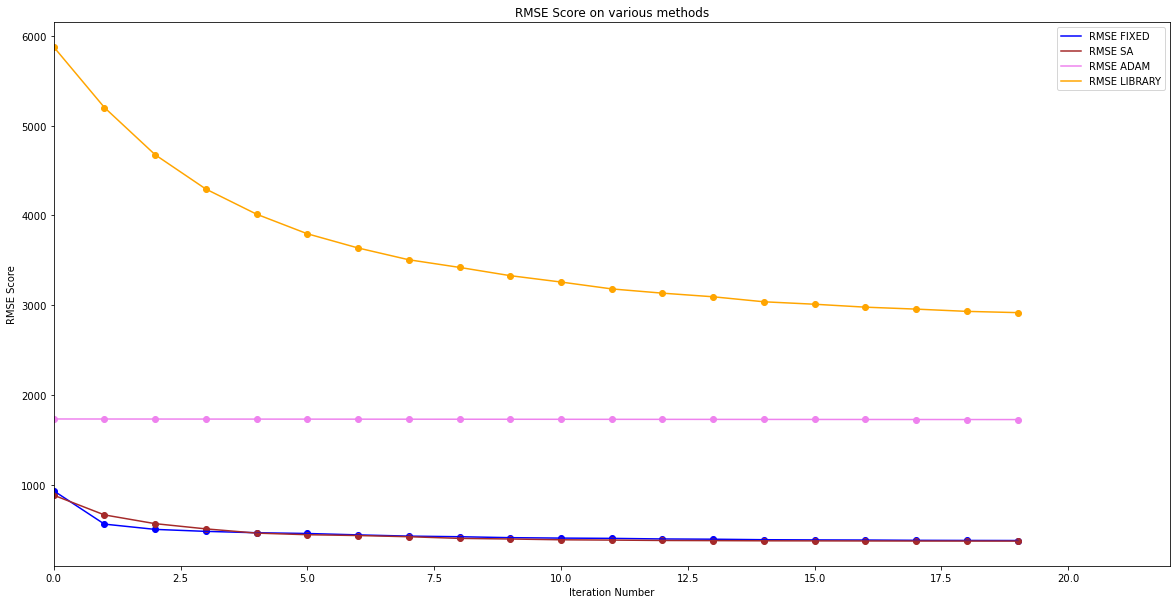

In [24]:
plt.figure(figsize=(20,10))

plt.plot(Rmse_Fixed, label='RMSE FIXED',color='blue')
plt.plot(Rmse_SA, label='RMSE SA',color='brown')
plt.plot(Rmse_Adam, label='RMSE ADAM',color='violet')
plt.plot(Rmse_Lib, label='RMSE LIBRARY',color='orange')
plt.scatter(range(len (Rmse_Fixed)), Rmse_Fixed, color='blue')
plt.scatter(range(len (Rmse_SA)), Rmse_SA, color='brown')
plt.scatter(range(len (Rmse_Adam)), Rmse_Adam, color='violet')
plt.scatter(range(len (Rmse_Lib)), Rmse_Lib, color='orange')

plt.xlim(0,22)
plt.xlabel('Iteration Number')
plt.ylabel('RMSE Score')

plt.title('RMSE Score on various methods')

plt.legend()
plt.show()

---------------------------------------------------------------------------------------------------------------

##### USING APPROXIMATE ALGORITHM

In [38]:
def Fit_Model_SD_Approx(learning_rate_method):
    with open('dataframe.pickle', 'rb') as f:
        new_df = pickle.load(f)
    new_df = new_df [(new_df['Datetime'] >= '2010-01') & (new_df['Datetime'] <= '2011-01')]
    # new_df = new_df [:100]
    new_df.reset_index(drop=True,inplace=True)
    X = new_df.drop(columns=['PJME_MW','Datetime'])
    Y = new_df['PJME_MW']

    model = GradientBoostRegressor()
    model.fit(X,Y,min_leaf = 5,depth = 5,boosting_rounds = 10,
            learning_rate=0.4,split_type="approximate",method=learning_rate_method,verbose=True)
    return model

In [39]:
model_fixed_approx = Fit_Model_SD_Approx("fixed")
Rmse_Fixed = model_fixed_approx.rmse

Boosting round 1 / 10 completed.
TRAINING LOSS:  3831.712631476516	


In [ ]:
model_SA_approx = Fit_Model_SD_Approx("simulated_annealing")
Rmse_SA = model_SA_approx.rmse

Boosting round 1 / 10 completed.
TRAINING LOSS:  1091.092455391989	
Boosting round 2 / 10 completed.
TRAINING LOSS:  655.421729124417	
Boosting round 3 / 10 completed.
TRAINING LOSS:  526.6019132719418	
Boosting round 4 / 10 completed.
TRAINING LOSS:  437.62440253239146	
Boosting round 5 / 10 completed.
TRAINING LOSS:  390.07623110109034	
Boosting round 6 / 10 completed.
TRAINING LOSS:  327.15573066799635	
Boosting round 7 / 10 completed.
TRAINING LOSS:  259.43790712426903	
Boosting round 8 / 10 completed.
TRAINING LOSS:  213.9774773607854	
Boosting round 9 / 10 completed.
TRAINING LOSS:  174.8564059270677	
Boosting round 10 / 10 completed.
TRAINING LOSS:  162.35838805015058	


In [ ]:
model_Adam_approx = Fit_Model_SD_Approx("adam")
Rmse_Adam = model_Adam_approx.rmse

Boosting round 1 / 10 completed.
TRAINING LOSS:  3111.3627909808265	
Boosting round 2 / 10 completed.
TRAINING LOSS:  3111.0477723756985	
Boosting round 3 / 10 completed.
TRAINING LOSS:  3110.732778012354	
Boosting round 4 / 10 completed.
TRAINING LOSS:  3110.4178097131758	
Boosting round 5 / 10 completed.
TRAINING LOSS:  3110.095841684069	
Boosting round 6 / 10 completed.
TRAINING LOSS:  3109.772150404916	
Boosting round 7 / 10 completed.
TRAINING LOSS:  3109.4477265275414	
Boosting round 8 / 10 completed.
TRAINING LOSS:  3109.122973037206	
Boosting round 9 / 10 completed.
TRAINING LOSS:  3108.7980919512966	
Boosting round 10 / 10 completed.
TRAINING LOSS:  3108.473195179802	


In [ ]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)
    # new_df=new_df[:10]
    new_df = new_df [(new_df['Datetime'] >= '2010-01') & (new_df['Datetime'] <= '2012-01')]

X=new_df.drop(columns = ['PJME_MW','Datetime'])
y=new_df['PJME_MW']

model_Lib = GradientBoostingRegressor(n_estimators=10, learning_rate=0.2, max_depth=5, random_state=42)
model_Lib.fit(X, y)
Rmse_Lib = []

# Iterate over the predictions at each stage and calculate RMSE
for i, y_pred in enumerate(model_Lib.staged_predict(X)):
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    Rmse_Lib.append(rmse)
    print(f"Iteration {i+1}: RMSE = {rmse}")

Iteration 1: RMSE = 5875.3191028452375
Iteration 2: RMSE = 5200.370107943789
Iteration 3: RMSE = 4674.4795601560845
Iteration 4: RMSE = 4292.364560048271
Iteration 5: RMSE = 4012.41972283763
Iteration 6: RMSE = 3794.42911756857
Iteration 7: RMSE = 3636.3916652583953
Iteration 8: RMSE = 3505.108386345001
Iteration 9: RMSE = 3420.059237229758
Iteration 10: RMSE = 3328.016071810484


NameError: name 'model_fixed_approx' is not defined

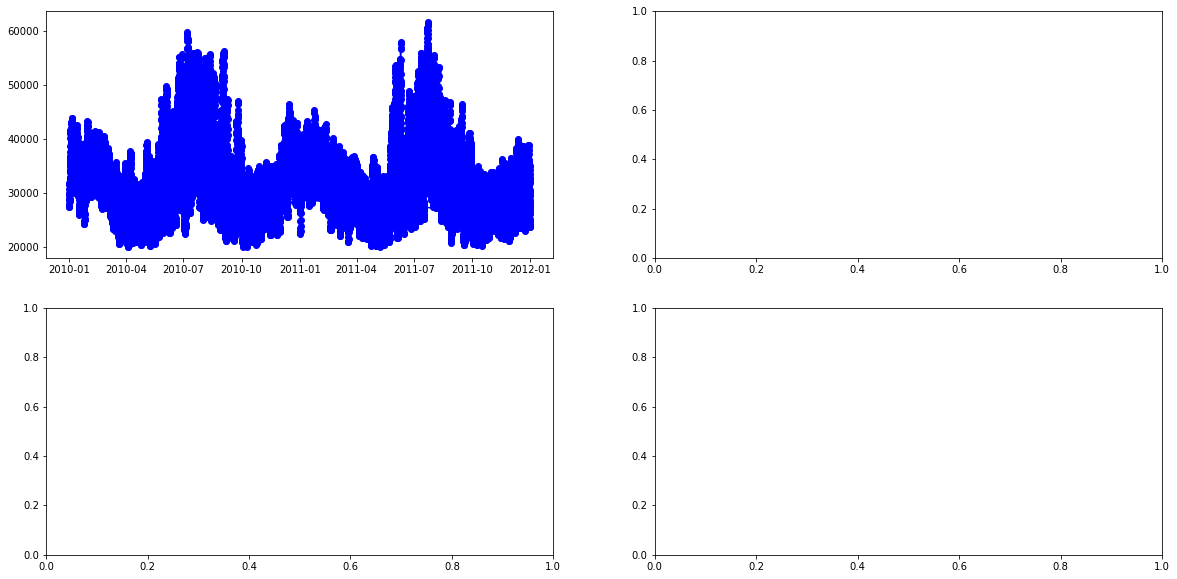

In [ ]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)
new_df = new_df [(new_df['Datetime'] >= '2010-01') & (new_df['Datetime'] <= '2012-01')]
X = new_df.drop(columns=['PJME_MW','Datetime'])
Y = new_df['PJME_MW']


fig, axs = plt.subplots(2, 2, figsize=(20, 10))

axs[0, 0].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[0, 0].plot(new_df['Datetime'], model_fixed_approx.predict(X), label='predicted',color='red', marker='s')
axs[0, 0].set_ylim(20_000, 60_000)
axs[0, 0].set_title('Actual vs Predicted PJME_MW by XGBoost (Fixed lr)')
axs[0, 0].set_xlabel('Datetime')
axs[0, 0].set_ylabel('PJME_ME')
axs[0, 0].grid(True)

axs[0, 1].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[0, 1].plot(new_df['Datetime'], model_SA_approx.predict(X), label='predicted',color='brown', marker='s')
axs[0, 1].set_ylim(20_000, 60_000)
axs[0, 1].set_title('Actual vs Predicted PJME_MW by XGBoost (Simulated Annealing lr)')
axs[0, 1].set_xlabel('Datetime')
axs[0, 1].set_ylabel('PJME_ME')
axs[0, 1].grid(True)

axs[1, 0].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[1, 0].plot(new_df['Datetime'], model_Adam_approx.predict(X), label='predicted',color='violet', marker='s')
axs[1, 0].set_ylim(20_000, 60_000)
axs[1, 0].set_title('Actual vs Predicted PJME_MW by XGBoost (Adam lr)')
axs[1, 0].set_xlabel('Datetime')
axs[1, 0].set_ylabel('PJME_ME')
axs[1, 0].grid(True)

axs[1, 1].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[1, 1].plot(new_df['Datetime'], model_Lib.predict(X), label='predicted',color='orange', marker='s')
axs[1, 1].set_ylim(20_000, 60_000)
axs[1, 1].set_title('Actual vs Predicted PJME_MW by XGBoost  (Library)')
axs[1, 1].set_xlabel('Datetime')
axs[1, 1].set_ylabel('PJME_ME')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(Rmse_Fixed, label='RMSE FIXED',color='blue')
plt.plot(Rmse_SA, label='RMSE SA',color='brown')
plt.plot(Rmse_Adam, label='RMSE ADAM',color='violet')
plt.plot(Rmse_Lib, label='RMSE LIBRARY',color='orange')
plt.scatter(range(len (Rmse_Fixed)), Rmse_Fixed, color='blue')
plt.scatter(range(len (Rmse_SA)), Rmse_SA, color='brown')
plt.scatter(range(len (Rmse_Adam)), Rmse_Adam, color='violet')
plt.scatter(range(len (Rmse_Lib)), Rmse_Lib, color='orange')

plt.xlim(0,12)
plt.xlabel('Iteration Number')
plt.ylabel('RMSE Score')

plt.title('RMSE Score on various methods')

plt.legend()
plt.show()

---------------------------------------------------------------------------------------------------------------

# GRID SEARCH 

In [27]:
def hyperparameter_tuning(X, y, depth, min_leaf, learning_rate, boosting_rounds, min_child_weight):

    # Define the parameter grid
    param_grid = {
        'depth': depth,
        'min_leaf': min_leaf,
        'learning_rate': learning_rate,
        'boosting_rounds': boosting_rounds,
    }

    model = GradientBoostRegressor()
    old_rmse=1e8
    params=[]

    for depth in param_grid['depth']:
        for min_leaf in param_grid['min_leaf']:
                for learning_rate in param_grid['learning_rate']:
                    for boosting_rounds in param_grid['boosting_rounds']:
                            model.fit(X,y , depth=depth, min_leaf=min_leaf, learning_rate=learning_rate, boosting_rounds=boosting_rounds, verbose=False)
                            predictions = model.predict(X)
                            Actual_Values = np.array(y)
                            rmse = np.sqrt(np.mean((predictions - Actual_Values)**2))
                            if rmse<old_rmse:
                                    old_rmse=rmse     
                                    params=[depth,min_leaf,learning_rate,boosting_rounds,min_child_weight]


    print("RMSE: " + str(old_rmse))
    print(params)
    return params

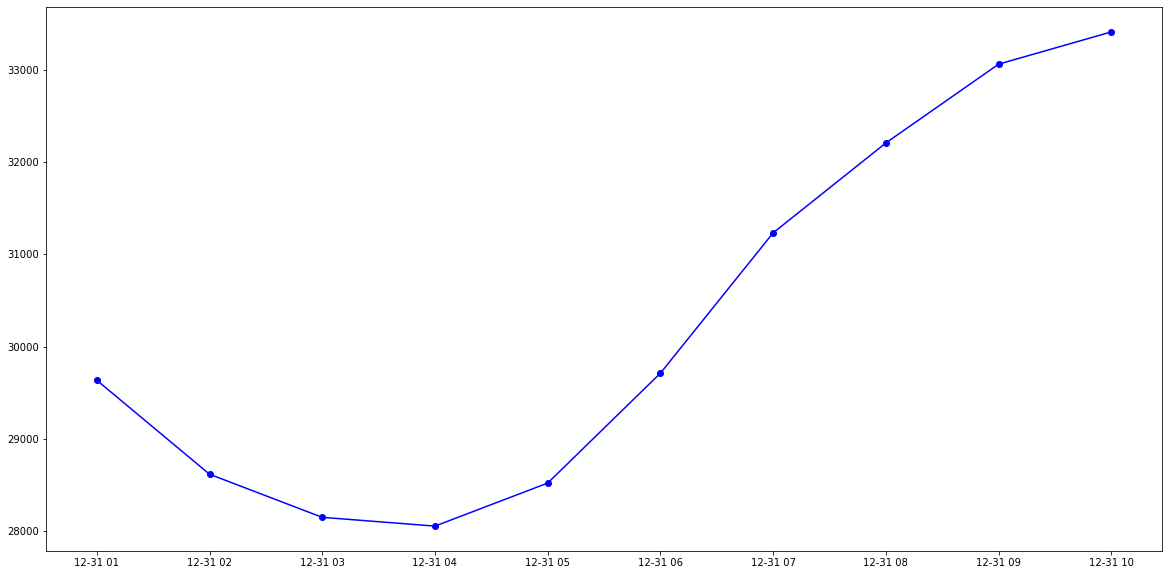

In [28]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)

new_df = new_df [(new_df['Datetime'] >= '2010-06-12') & (new_df['Datetime'] <= '2011-01-01')]
new_df = new_df[:10]
new_df=new_df.reset_index(drop=True)
X = new_df.drop(columns=['PJME_MW','Datetime'])
Y = new_df['PJME_MW']

plt.figure(figsize=(20,10))
plt.plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')

In [29]:
parameters = hyperparameter_tuning(X,Y,[2, 4], [3,7], [0.1, 0.5], [3,5], [3,7])

RMSE: 415.90382998495517
[2, 3, 0.1, 5, [3, 7]]


-------------------------------------------------------------------------------------------

# K-FOLD CROSS VALIDATION

In [30]:
def Fit_Model_SD_Kfold(learning_rate_method):
    with open('dataframe.pickle', 'rb') as f:
        new_df = pickle.load(f)
    new_df = new_df [(new_df['Datetime'] >= '2010-01') & (new_df['Datetime'] <= '2011-01')]
    new_df=new_df[:30]
    new_df.reset_index(drop=True,inplace=True)
    X = new_df.drop(columns=['PJME_MW','Datetime'])
    Y = new_df['PJME_MW']
    
    model = GradientBoostRegressor()
    model.fit(X,Y,depth=parameters[0],
              min_leaf = parameters[1],
              boosting_rounds = parameters[3],
              learning_rate=parameters[2],
              split_type="greedy",
              method=learning_rate_method,
              verbose=False, 
              k_fold_cross_validation=True)
    return model

In [31]:
model_fixed = Fit_Model_SD_Kfold("fixed")
print("Fixed Done!")
# model_SA = Fit_Model_SD_Kfold("simulated_annealing")
# print("Simulated Done!")
# model_Adam = Fit_Model_SD_Kfold("adam")
# print("Adam Done!")

Fixed Done!
